## Import packages

In [2]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize, differential_evolution, LinearConstraint
import os
import nibabel as nib
import matplotlib.pyplot as plt
from kneed import KneeLocator
from dbsi_fns import *
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

## Navigate to folder and load data.

In [3]:
os.chdir('/Users/willi3by/Desktop/')
basis_tensors = loadmat('/Users/willi3by/Desktop/dbsipy/dbset_100.mat')['xx']
bvalues = np.loadtxt('/Users/willi3by/Desktop/Scanner_Resources/Master_DWI_files/DBSI/DBSI_bval_orig.txt')
bvecs = np.loadtxt('/Users/willi3by/Desktop/Scanner_Resources/Master_DWI_files/DBSI/DBSI_bvec_orig.txt')
dbsi = nib.load('/Users/willi3by/Desktop/21425171/_R_Woo_ROSE_LAWN_20230823120555_7.nii').get_fdata()[...,1:]

## Sort data based on b-value (makes plotting easier).

In [4]:
#Sort b-values and get sorted indices to sort bvecs and dbsi data.
bvalues_sorted = np.sort(bvalues)
bvalues_sorted_indices = np.argsort(bvalues)
bvecs_sorted = bvecs[bvalues_sorted_indices,:]
dbsi_sorted = dbsi[...,bvalues_sorted_indices]

## Plot image with voxel that is being analyzed.

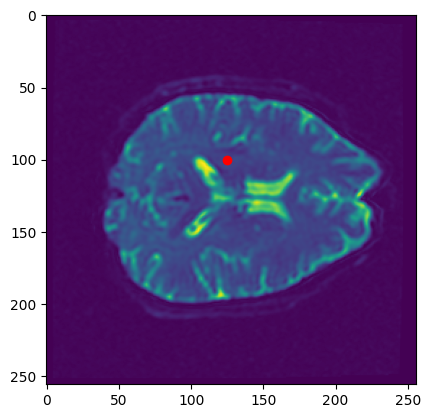

In [7]:
#plot 2d slice and highlight specific voxel
plt.imshow(dbsi_sorted[:,:,30,0])
plt.scatter(125,100, color='red')

## Plot signal from voxel.

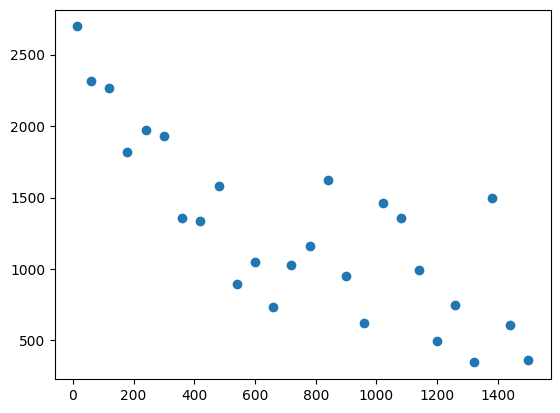

In [5]:
dbsi_vox = dbsi_sorted[125,100,30,:]
plt.plot(bvalues_sorted, dbsi_vox, 'o')

## Calulcate theta matrix for all basis tensors.

In [6]:
theta_matrix = get_theta_matrix(basis_tensors, bvecs_sorted)

## Initialize parameters for fitting c values.

In [7]:
# Replace number_of_c_values with the actual number of elements in c_i
number_of_c_values = 100  # Replace with the actual number

# Initial guess for the optimization
# initial_guess_np = np.concatenate((np.array([0.0001, 0.0001, 0.0001, 0.1]), np.random.normal(size=number_of_c_values)))
initial_guess_np = np.concatenate((np.array([0.0001, 0.0001, 0.0001, 0.1]), np.ones(number_of_c_values)))

# Set up the bounds for the differential evolution algorithm
bounds_c = [(0, 0.002), (0, 0.002), (0, 0.01), (0, 100)] + [(0, 100) for _ in range(number_of_c_values)]
l2_penalty = 0.01


In [9]:
lambda_parallel, lambda_perp, d_iso, c_Nplus1, c_values, error_term = fit_voxel_c(dbsi_vox, bvalues_sorted, theta_matrix, bounds=bounds_c, alpha=0.01, maxiter=500)

differential_evolution step 1: f(x)= 9.9574e+06
differential_evolution step 2: f(x)= 9.52166e+06
differential_evolution step 3: f(x)= 8.6717e+06
differential_evolution step 4: f(x)= 8.439e+06
differential_evolution step 5: f(x)= 8.08848e+06
differential_evolution step 6: f(x)= 7.69828e+06
differential_evolution step 7: f(x)= 7.69828e+06
differential_evolution step 8: f(x)= 7.69828e+06
differential_evolution step 9: f(x)= 7.69828e+06
differential_evolution step 10: f(x)= 6.82426e+06
differential_evolution step 11: f(x)= 6.82426e+06
differential_evolution step 12: f(x)= 6.82426e+06
differential_evolution step 13: f(x)= 5.62717e+06
differential_evolution step 14: f(x)= 5.62717e+06
differential_evolution step 15: f(x)= 5.62717e+06
differential_evolution step 16: f(x)= 5.62717e+06
differential_evolution step 17: f(x)= 5.62717e+06
differential_evolution step 18: f(x)= 5.2275e+06
differential_evolution step 19: f(x)= 5.2275e+06
differential_evolution step 20: f(x)= 5.2275e+06
differential_evo

In [10]:
# Print the result
print("Optimized lambda parallel:", lambda_parallel)
print("Optimized lambda perpendicular:", lambda_perp)
print("Optimized d_iso:", d_iso)
print("Optimized c_Nplus1:", c_Nplus1)
print("Onjective Function Value:", error_term)

Optimized lambda parallel: 0.0
Optimized lambda perpendicular: 0.001596476198524669
Optimized d_iso: 0.005117801807341535
Optimized c_Nplus1: 57.94567892718387
Onjective Function Value: 1799704.933575783


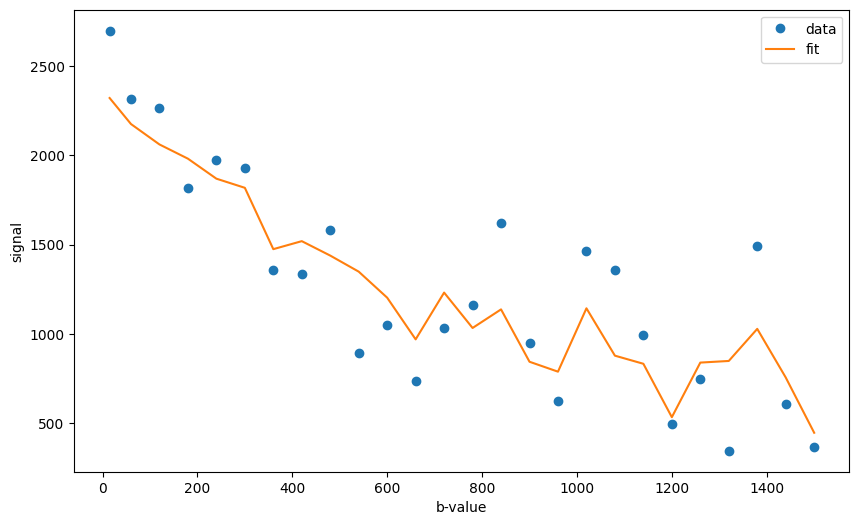

In [12]:
plot_c_fit(bvalues_sorted, dbsi_vox, theta_matrix, lambda_parallel, lambda_perp, d_iso, c_Nplus1, c_values)

In [13]:
gmm, c_clusters, n_components = get_c_clusters(c_values)

In [8]:
plt.plot(c_clusters)

NameError: name 'c_clusters' is not defined

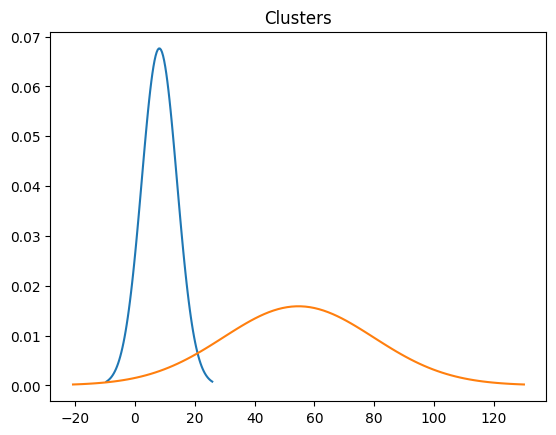

In [14]:
#Plot 2d norm pdf of each cluster
fig, ax = plt.subplots()
for i in range(n_components):
    mean = gmm.means_[i,0]
    std = np.sqrt(gmm.covariances_[i,0,0])
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    ax.plot(x, norm.pdf(x, mean, std))
    ax.set_title('Clusters')


In [15]:
#Get mean of basis tensors for each cluster
mean_tensors = np.zeros((n_components, 3))
for i in range(n_components):
    mean_tensors[i,:] = np.mean(basis_tensors[c_clusters==i,:], axis=0)

theta_matrix = get_theta_matrix(mean_tensors, bvecs_sorted)


In [16]:
a = 0
b = 0.003
L = 20
v = (b-a)/(L-1)
fd_range = np.arange(a, b+v, v)

In [17]:
bounds_f = [(0, 0.002) for _ in range(theta_matrix.shape[0])] + [(0, 0.002) for _ in range(theta_matrix.shape[0])] + [(0, 1000) for _ in range(fd_range.shape[0] + theta_matrix.shape[0])]

In [18]:
opt_lambda_parallel, opt_lambda_perp, opt_f_values, error_term = fit_voxel_f(dbsi_vox, bvalues_sorted, theta_matrix, fd_range, bounds=bounds_f, l2_penalty=0.01, maxiter=500)

differential_evolution step 1: f(x)= 7.581e+07
differential_evolution step 2: f(x)= 5.82261e+07
differential_evolution step 3: f(x)= 4.24396e+07
differential_evolution step 4: f(x)= 4.15923e+07
differential_evolution step 5: f(x)= 3.04177e+07
differential_evolution step 6: f(x)= 3.04177e+07
differential_evolution step 7: f(x)= 1.99085e+07
differential_evolution step 8: f(x)= 1.99085e+07
differential_evolution step 9: f(x)= 1.99085e+07
differential_evolution step 10: f(x)= 1.66399e+07
differential_evolution step 11: f(x)= 1.66399e+07
differential_evolution step 12: f(x)= 1.66399e+07
differential_evolution step 13: f(x)= 1.55518e+07
differential_evolution step 14: f(x)= 1.55518e+07
differential_evolution step 15: f(x)= 1.37962e+07
differential_evolution step 16: f(x)= 1.18941e+07
differential_evolution step 17: f(x)= 1.04771e+07
differential_evolution step 18: f(x)= 7.90402e+06
differential_evolution step 19: f(x)= 6.88863e+06
differential_evolution step 20: f(x)= 6.53218e+06
differentia

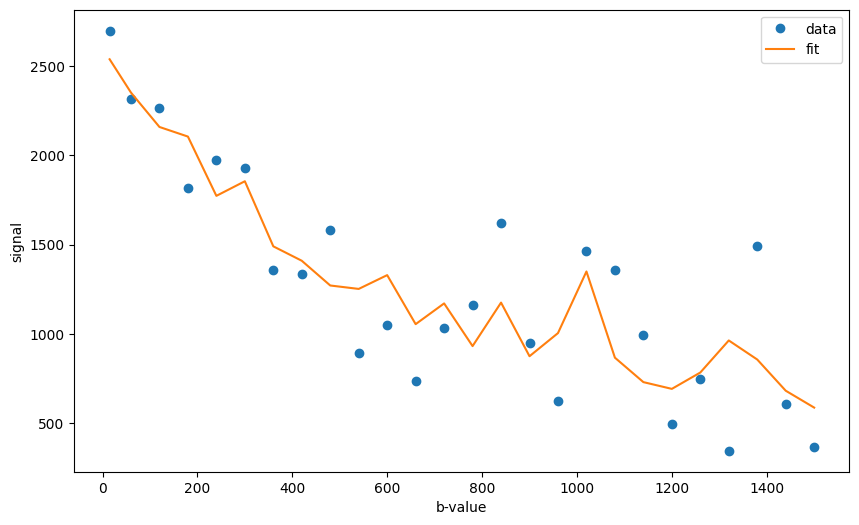

In [21]:
plot_f_fit(bvalues_sorted, dbsi_vox, theta_matrix, fd_range, opt_lambda_parallel, opt_lambda_perp, opt_f_values)

In [26]:
def calc_fa(opt_lambda_parallel, opt_lambda_perp):
    return np.sqrt(1/2)*(np.sqrt((opt_lambda_perp - opt_lambda_parallel)**2 +  (opt_lambda_perp - opt_lambda_parallel)**2)/np.sqrt(opt_lambda_parallel**2 + opt_lambda_perp**2))

In [27]:
calc_fa(opt_lambda_parallel, opt_lambda_perp)

array([0.8926031, 1.       ])

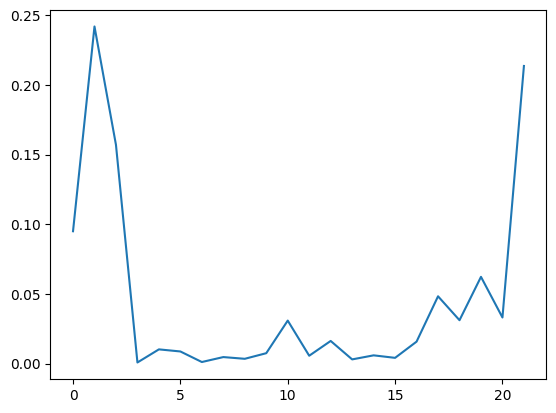

In [22]:
plt.plot(opt_f_values/np.sum(opt_f_values))

In [23]:
scaled_f_values = opt_f_values/np.sum(opt_f_values)

In [24]:
scaled_f_values

array([0.09499105, 0.24201019, 0.15703351, 0.00076857, 0.01017615,
       0.008675  , 0.00109776, 0.00464502, 0.00340889, 0.00743197,
       0.03084211, 0.00561157, 0.0162234 , 0.00297973, 0.00588933,
       0.00409147, 0.01573484, 0.04828658, 0.03111981, 0.06225388,
       0.03307287, 0.21365627])